In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import json


In [15]:
temp_data_train = pd.read_csv('../../Data/train_data_HDD.csv')
temp_data_test  = pd.read_csv('../../Data/test_data_HDD.csv')

# Convert the 'date' column to datetime
temp_data_train['date'] = pd.to_datetime(temp_data_train['date'])
temp_data_test['date']  = pd.to_datetime(temp_data_test['date'])

temp_data_train['average_temperature']  = (temp_data_train['min']+temp_data_train['max'])/2
temp_data_test['average_temperature']   = (temp_data_test['min']+temp_data_test['max'])/2

T_actual_train  = temp_data_train['average_temperature'].to_numpy()
T_actual_test   = temp_data_test['average_temperature'].to_numpy()

temp_data_test.head()

,date,mean,max,min,average_temperature
0,2024-07-01,26.44,37.89,14.22,26.055
1,2024-07-02,25.33,36.72,13.78,25.250
2,2024-07-03,28.11,38.50,17.00,27.750
3,2024-07-04,27.72,38.50,17.00,27.750
4,2024-07-05,29.11,42.11,17.72,29.915


Linear and Seasonal forecast

In [ ]:
import json

with open("linear_trend_params.json", "r") as f:
    trend_values_dict = json.load(f)

# Forecast horizon
forecast_end = 93

# Match test set for later
T_actual_test = T_actual_test[:forecast_end]

# Create empty DataFrame with placeholders
forecast_df = pd.DataFrame(index=np.arange(forecast_end), columns=['date', 't', 'trend', 'seasonal', 'forecast', 'actual'])

# Assign actual values (truncate if necessary)
forecast_df['actual'] = T_actual_test[:forecast_end]

# Set date range starting from first test date
start_date          = temp_data_test['date'].iloc[0]
date_range          = pd.date_range(start=start_date, periods=forecast_end)
forecast_df['date'] = date_range

# Set time index t continuing from training period
start_t          = len(temp_data_train[temp_data_train['date'] >= '1950-01-01'])  #NOTE: this must be consistent with the last run in main
forecast_df['t'] = np.arange(start_t + 1, start_t + forecast_end + 1)

#Access the trend parameters
slope     = trend_values_dict["slope"]
intercept = trend_values_dict["intercept"]


# Calculate the trend using the linear equation
forecast_df['trend'] = intercept + slope*forecast_df['t']

# View the first few rows
print(forecast_df.head())

ValueError: Length of values (93) does not match length of index (94)

In [ ]:
import numpy as np
import json

# Load fitted parameters
with open("seasonal_mean_params.json", "r") as f:
    fitted_params = json.load(f)

# Define the same periods used in the fitting notebook
periods = [365, 730, 1460, 2920, 5840, 11680]
num_components = len(periods)

def forecast_seasonal(t, fitted_params):
    """
    Forecast seasonal component using fitted sinusoidal model.
    
    Parameters:
    t: array-like, time values to forecast on (e.g., future days)
    fitted_params: list, fitted parameters [C, a1, phi1, a2, phi2, ..., aN, phiN]
    
    Returns:
    array of forecasted seasonal values
    """
    C = fitted_params[0]
    seasonal_sum = np.zeros_like(t, dtype=float)
    
    for i in range(num_components):
        a_i = fitted_params[1 + 2 * i]
        phi_i = fitted_params[2 + 2 * i]
        p_i = periods[i]
        seasonal_sum += a_i * np.sin(2 * np.pi * (t - phi_i) / p_i)
    
    return C + seasonal_sum

# Forecasting for future time steps
t_future = np.arange(start_t + 1, start_t + forecast_end + 1)

# Generate forecast
seasonal_forecast = forecast_seasonal(t_future, fitted_params)

# Add seasonal forecast to the forecast dataframe
forecast_df['seasonal'] = seasonal_forecast[:forecast_end]

In [ ]:
forecast_df['residual'] = forecast_df['actual'] - forecast_df['trend'] - forecast_df['seasonal']
print(forecast_df.head())

        date      t      trend  seasonal forecast  actual  residual
0 2024-07-01  27203  18.460806  7.134535      NaN  26.055  0.459659
1 2024-07-02  27204  18.460839  7.169474      NaN  25.250 -0.380312
2 2024-07-03  27205  18.460871  7.202316      NaN  27.750  2.086812
3 2024-07-04  27206  18.460904  7.233053      NaN  27.750  2.056042
4 2024-07-05  27207  18.460937  7.261675      NaN  29.915  4.192388


DEBUG: Forcing CPU for computation.


/var/folders/8x/z8_ybmwx7tq_c10hj9qc7rx40000gn/T/ipykernel_6699/3572894831.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("wavelet_meanrev_checkpoint.

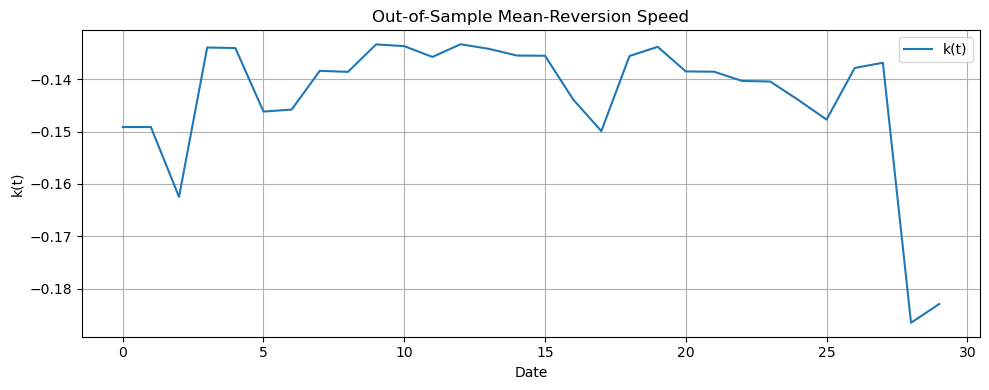

          k
0 -0.149147
1 -0.149147
2 -0.162471
3 -0.133967
4 -0.134071
           k
25 -0.147725
26 -0.137872
27 -0.136879
28 -0.186503
29 -0.182917


In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mean_rev_speed import WaveletNetwork, device

# 1) Load checkpoint & rebuild model
ckpt = torch.load("wavelet_meanrev_checkpoint.pth", map_location="cpu")
lags       = ckpt['lags']         # list of selected lag indices
hidden_dim = ckpt['hidden_dim']
state_dict = ckpt['model_state_dict']

# instantiate & load weights
wn = WaveletNetwork(input_dim=len(lags), hidden_dim=hidden_dim).to(device)
wn.load_state_dict(state_dict)
wn.eval()

# 2) Compute your residual series
# (assumes forecast_df already has 'actual', 'trend', 'seasonal')
forecast_df['residual'] = (
    forecast_df['actual']
  - forecast_df['trend']
  - forecast_df['seasonal']
)

# 3) Build a lag matrix ONLY for the selected lags
resid = forecast_df['residual']
df_lags = pd.concat(
    { f"lag_{i}": resid.shift(i+1) for i in lags },
    axis=1
).dropna()

# 4) Convert to a torch tensor
Xf = torch.tensor(df_lags.values, dtype=torch.float32).to(device)

# 5) Compute the Jacobian-based coefficients and k(t) = ∂ŷ/∂lag₁ – 1
grads = wn.partial_coefs(Xf)                  # shape (n_samples, len(lags))
k_out = grads[:, 0].cpu().numpy() - 1         # first column is lag-1

# 6) Align back into your DataFrame
k_series = pd.Series(k_out, index=df_lags.index, name='k')
forecast_df['k'] = k_series.reindex(forecast_df.index)
forecast_df['k'].fillna(method='bfill', inplace=True)

# 7) (Optional) Plot
plt.figure(figsize=(10,4))
plt.plot(forecast_df.index, forecast_df['k'], label="k(t)")
plt.title("Out-of-Sample Mean-Reversion Speed")
plt.xlabel("Date")
plt.ylabel("k(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Quick peek
print(forecast_df[['k']].head())
print(forecast_df[['k']].tail())

In [ ]:
print(forecast_df.head())
print(forecast_df.tail())

        date      t      trend  seasonal forecast  actual  residual         k
0 2024-07-01  27203  18.460806  7.134535      NaN  26.055  0.459659 -0.149147
1 2024-07-02  27204  18.460839  7.169474      NaN  25.250 -0.380312 -0.149147
2 2024-07-03  27205  18.460871  7.202316      NaN  27.750  2.086812 -0.162471
3 2024-07-04  27206  18.460904  7.233053      NaN  27.750  2.056042 -0.133967
4 2024-07-05  27207  18.460937  7.261675      NaN  29.915  4.192388 -0.134071
         date      t      trend  seasonal forecast  actual  residual         k
25 2024-07-26  27228  18.461626  7.364570      NaN  29.305  3.478804 -0.147725
26 2024-07-27  27229  18.461658  7.345613      NaN  27.360  1.552729 -0.137872
27 2024-07-28  27230  18.461691  7.324504      NaN  24.000 -1.786195 -0.136879
28 2024-07-29  27231  18.461724  7.301249      NaN  24.195 -1.567973 -0.186503
29 2024-07-30  27232  18.461757  7.275856      NaN  24.335 -1.402613 -0.182917


In [ ]:
# 1) Make sure your index is datetime
if not isinstance(forecast_df.index, pd.DatetimeIndex):
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])
    forecast_df = forecast_df.set_index('date')

# 2) Load your fitted sinusoid params
with open("variance_params.json", "r") as f:
    params = json.load(f)
# params = [c0, a1, b1, a2, b2, …]

# 3) Define a generic harmonics‐based variance forecast
def forecast_sigmaboy(doys, params):
    c0 = params[0]
    harmonics = np.array(params[1:]).reshape(-1, 2)  # each row = [a_i, b_i]
    sig2 = np.full_like(doys, fill_value=c0, dtype=float)
    for i, (ai, bi) in enumerate(harmonics, start=1):
        angle = 2 * np.pi * i * doys / 365
        sig2 += ai * np.cos(angle) + bi * np.sin(angle)
    return sig2

# 4) Compute day‐of‐year array for every forecast date
doys = forecast_df.index.dayofyear.to_numpy()  # e.g. [150, 151, 152, …]

# 5) Get σ^2 and then σ
sig2 = forecast_sigmaboy(doys, params)
forecast_df['sigmaboy'] = np.sqrt(np.maximum(sig2, 0.0))

# 6) Quick check
print(forecast_df[['sigmaboy']].head())

            sigmaboy
date                
2024-07-01  1.445176
2024-07-02  1.435336
2024-07-03  1.425726
2024-07-04  1.416371
2024-07-05  1.407295


In [ ]:
print(forecast_df.head())
print(forecast_df.tail())

                t      trend  seasonal forecast  actual  residual         k  \
date                                                                          
2024-07-01  27203  18.460806  7.134535      NaN  26.055  0.459659 -0.149147   
2024-07-02  27204  18.460839  7.169474      NaN  25.250 -0.380312 -0.149147   
2024-07-03  27205  18.460871  7.202316      NaN  27.750  2.086812 -0.162471   
2024-07-04  27206  18.460904  7.233053      NaN  27.750  2.056042 -0.133967   
2024-07-05  27207  18.460937  7.261675      NaN  29.915  4.192388 -0.134071   

            sigmaboy  
date                  
2024-07-01  1.445176  
2024-07-02  1.435336  
2024-07-03  1.425726  
2024-07-04  1.416371  
2024-07-05  1.407295  
                t      trend  seasonal forecast  actual  residual         k  \
date                                                                          
2024-07-26  27228  18.461626  7.364570      NaN  29.305  3.478804 -0.147725   
2024-07-27  27229  18.461658  7.345613      NaN 

Mean Absolute Error (MAE): 2.3009330298074904
Mean Squared Error (MSE): 6.649651814578929
Root Mean Squared Error (RMSE): 2.5786918805043246
Correlation Coefficient: 0.3168315147314116


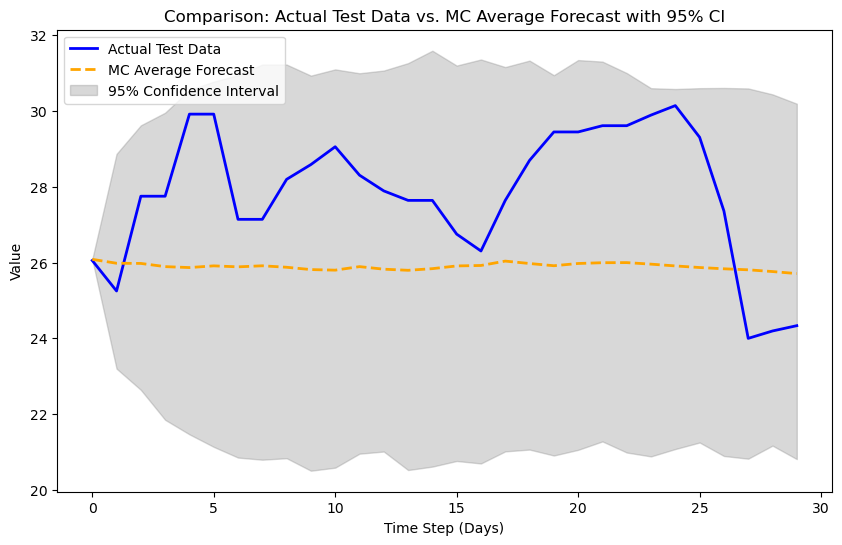

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Existing Monte Carlo simulation code ---
n_paths = 1000                   # Number of Monte Carlo simulation paths

# Assume forecast_end, T_actual_train, T_actual_test, and forecast_df are defined elsewhere
# For example, T_actual_train and T_actual_test could be numpy arrays, and forecast_df a DataFrame

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    previous_value = T_all[:, t-1]
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + forecast_df['k'].iloc[t] * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )


# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# --- Compute error statistics between T_avg and T_actual_test ---
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# --- Plot the Actual Test Data vs. MC Average Forecast with Confidence Interval ---
# Compute confidence interval bounds from the Monte Carlo simulation:
# For a 95% confidence interval, get the 2.5th and 97.5th percentiles.
lower_ci = np.percentile(T_all, 2.5, axis=0)
upper_ci = np.percentile(T_all, 97.5, axis=0)

plt.figure(figsize=(10, 6))

# Assuming T_actual_test and T_avg have the same length as forecast_end.
time_steps = np.arange(forecast_end)  # or adjust as needed

# Plot actual test data and average forecast
plt.plot(time_steps, T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(time_steps, T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')

# Add the confidence interval as a shaded area.
plt.fill_between(time_steps, lower_ci, upper_ci, color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast with 95% CI")
plt.legend()
plt.show()

In [ ]:
# --- Compute confidence intervals and average as before ---
lower_ci = np.percentile(T_all, 2.5, axis=0)
upper_ci = np.percentile(T_all, 97.5, axis=0)
T_avg = np.mean(T_all, axis=0)

# --- Save results to JSON ---
# Create a dictionary with lists (convert NumPy arrays to native Python lists)
forecast_stats = {
    "mean_forecast": T_avg.tolist(),
    "lower_ci_95": lower_ci.tolist(),
    "upper_ci_95": upper_ci.tolist()
}

# Save to JSON file
with open("forecast_mc_results.json", "w") as f:
    json.dump(forecast_stats, f, indent=4)

print("Forecast statistics saved to forecast_mc_results.json")

Forecast statistics saved to forecast_mc_results.json


In [ ]:
print(np.isnan(T_actual_test).sum())  # Number of NaNs in T_actual_test
print(np.isnan(T_avg).sum())          # Number of NaNs in T_avg

0
0


Mean Absolute Error (MAE): 0.8613555141534807
Mean Squared Error (MSE): 1.4169465843527365
Root Mean Squared Error (RMSE): 1.190355654564104
Correlation Coefficient: 0.742380338233607


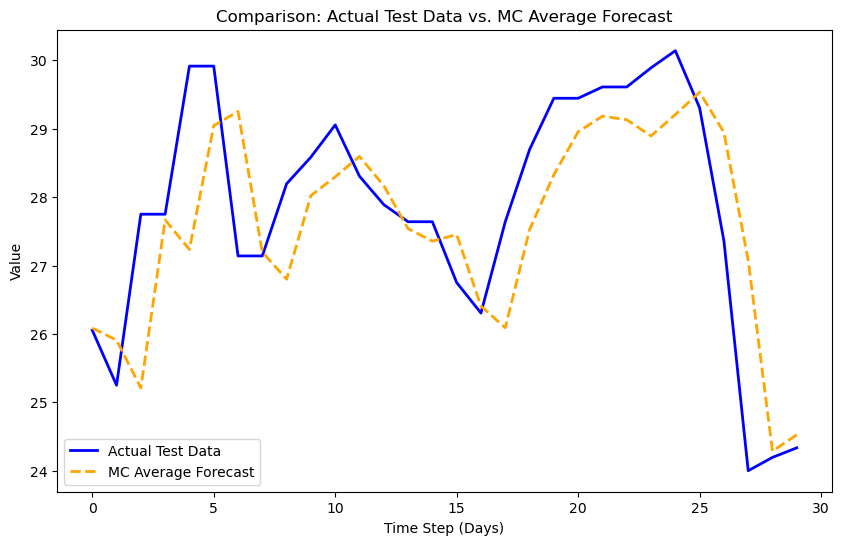

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

n_paths = 100     # number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    # Use the actual observed data at t-1 if available, otherwise fall back on the simulation
    if t-1 < len(T_actual_test):
        previous_value = T_actual_test[t-1]
    else:
        # If actual data is not available (e.g., beyond the test sample), you may use the forecasted average:
        previous_value = np.mean(T_all[:, t-1])
    
    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + forecast_df['k'].iloc[t] * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )

# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()